In [1]:
from pytimekr import pytimekr
from datetime import datetime
import sys
import math
import calendar
from sklearn.metrics import mean_squared_error
import lightgbm as lgb

import matplotlib.pyplot as plt 
%matplotlib inline 
plt.rcParams['font.family'] = 'NanumGothic'

import pandas as pd 
import numpy as np 

import warnings 
warnings.filterwarnings('ignore')


from sklearn.preprocessing import LabelEncoder

# 변수 생성을 위한 함수

In [2]:
def fill_2012(train,var) : 
    lst = train[(train['year']=='2013')& (train['month'] >=11)][var].reset_index()[var]
    fillna_idx = train[(train['year']=='2012')&(train[var]).isnull()].index
    for i in range(len(fillna_idx)):
        train.at[fillna_idx[i],var]=lst[i]

In [3]:
def fill_2015(train,var) : 
    lst = train[(train['year']=='2014')& (train['month'] ==5)& (train['day'] >=21)][var].reset_index()[var]
    fillna_idx = train[(train['year']=='2015')&(train[var]).isnull()].index
    for i in range(len(fillna_idx)):
        train.at[fillna_idx[i],var]=lst[i]

In [4]:
def fill_2014(train,var) : 
    lst = train[(train['year']=='2015')& (train['month'] ==12)][var].reset_index()[var]
    fillna_idx = train[(train['year']=='2014')&(train[var]).isnull()].index
    for i in range(len(fillna_idx)):
        train.at[fillna_idx[i],var]=lst[i]

In [5]:
def day(date):
    date_convert = datetime.strptime(date, '%Y%m%d').date()
    days = ['월', '화', '수', '목', '금', '토', '일']
    day = date_convert.weekday()
    return days[day]

In [6]:
def season(m):
    if 3<=m<=5:
        m='봄'
    elif 6<=m<=8:
        m='여름'
    elif 9<=m<=11:
        m='가을'
    else:
        m='겨울'
    return m

In [7]:
def pm10_class(p) :
    if 0<=p<=30 :
        p = 'good'
    elif 30<p<=80 :
        p = 'normal'
    elif 80<p<=150 :
        p = 'bad'
    else :
        p = 'worst'
    return p

In [8]:
def body(m,t,w,r):
    if 4< m <10:
        tw=t*math.atan(0.151977*math.sqrt(r+8.313659))+math.atan(r+t)-\
        math.atan(r-1.67633)+0.00391833*(math.sqrt(r)**3)*math.atan(0.23101*r)-4.606835
        data=-0.2442+0.55399*tw+0.45535*t-0.0022*tw**2+0.00278*tw*t+3.5
    else:
        data=13.12+0.6215*t-11.37*w**0.16+0.3965*t*w**0.16
    return  data

In [9]:
def max_min_class(m) :
    if 0<=m<=7 :
        m = 'low'
    elif 7<m<=12 :
        m = 'middle'
    else :
        m = 'high'
    return m

In [10]:
def score(df,val,area,score,Val_score):
    score_idx=df[df['stn_id']==area].index
    area2 = Val_score[area]
    if Val_score==Val_ta:
        score[score_idx]=df[(df['stn_id']==area)&((df[val]==0)|(df[val]))][val].\
        apply(lambda x: '4' if x<area2[0] else ('3' if area2[0]<=x<area2[1] else ('2' if  area2[1]<=x<area2[2]  else '1')))
    else:
        score[score_idx]=df[(df['stn_id']==area)&(df[val])][val].\
        apply(lambda x: '4' if x>=area2[0] else ('3' if area2[1]<=x<area2[0] else ('2' if  area2[2]<=x<area2[1]  else '1')))
    return score 

In [11]:
Val_ta={'서울':[-8.1,0.6,13.5],'경기':[-9.0,-1.1,12.2],'인천':[-7.1,1.0,13.5], '충북': [-8.2,-0.6,12.6],
        '충남': [-7.7,-0.5,12.6],'대전': [-7.7,-0.5,12.6], '세종': [-7.7,-0.5,12.6], '대구':[-4.8,1.6,13.8],
        '경북':[-4.8,1.6,13.8],'전북':[-6.6,0.1,13.8],'울산':[-3.9,2.5,13.8],'경남':[-3.1,3.5,14.9],
       '광주':[-4.8,1.4,13.7],'부산':[-2.9,4.7,15.1],'전남':[-3.3,2.3,14.0],'제주':[-1.7,6.5,16.0],'강원':[-8.8,-0.5,12] }
Val_pa={'서울':[1017.9,1011.9,1003.5],'경기':[1024.7,1018.5,1009.9],'인천':[1020.2,1014.1,1005.7],
        '충북': [1021.7,1015.6,1007.2],'충남': [1020.2,1014.1,1005.8],'대전': [1020.2,1014.1,1005.8],
        '세종': [1020.2,1014.1,1005.8],'대구':[1020.7,1014.7,1007.0],'경북':[1020.7,1014.7,1007.0],
        '전북':[1022.1,1016.2,1007.6],'울산':[1022.7,1016.8,1009.6],'경남':[1024.5,1018.0,1010.4],
       '광주':[1019.6,1013.8,1005.5],'부산':[1018.1,1012.5,1005.4],'전남':[1023.7,1017.9,1009.4],
        '제주':[1025.6,1019.8,1009.4],'강원':[1021.45,1019.75,1007.45] }
Val_rhm={'서울':[86.5,72.4,57.3],'경기':[89.6,78.1,63.9],'인천':[90.4,78.8,63.1], '충북': [86.0,73.4,59.9],
        '충남': [88.0,75.1,62.5],'대전': [88.0,75.1,62.5], '세종': [88.0,75.1,62.5], '대구':[84.6,69.0,52.8],
        '경북':[84.6,69.0,52.8],'전북':[86.5,75.0,63.5],'울산':[88.3,76.0,59.5],'경남':[87.3,75.4,57.5],
       '광주':[89.1,76.5,64.1],'부산':[89.9,77.0,58.0],'전남':[94.5,84.3,72.8],'제주':[86.4,75.1,62.0],'강원':[90.3,77.85,59.35]}
Val_dtr={'서울':[12.5,9.9,7.3],'경기':[15.1,11.7,8.4],'인천':[11.7,9.2,6.8], '충북': [16.0,12.4,8.7],
        '충남': [15.8,12.3,8.6],'대전': [15.8,12.3,8.6], '세종': [15.8,12.3,8.6], '대구':[15.5,12.0,8.7],
        '경북':[15.5,12.0,8.7],'전북':[16.4,12.9,9.1],'울산':[15.1,11.5,8.4],'경남':[12.5,10.0,7.5],
       '광주':[15.6,11.9,8.2],'부산':[11.2,9.0,6.8],'전남':[12.1,9.4,6.7],'제주':[10.1,7.4,5.0],'강원':[15.3,11.9,8.65] }

In [12]:
def ti_level(x):
    if 1<=x<1.3877:
        x = '4'
    elif 1.3877<=x<2.7731:
        x = '3'
    elif 2.7731<=x<3.213:
        x = '2'
    else :
        x = '1'
    return x

In [13]:
def elder_rate_class(m) :
    if 0<=m<7 :
        m = '성숙인구사회'
    elif 7<=m<14 :
        m = '고령화사회'
    elif 14<=m<20 :
        m = '고령사회'
    else :
        m = '초고령사회'
    return m

In [14]:
fill_pairs = {
    '강원' : '경북',  '충북' : '충남', '경남' : '경북',  '대전' : '충북',  '세종' : '충북', '광주' : '전북',
    '대구' : '경북',  '부산' : '경남', '서울' : '경기',  '울산' : '경남',  '전북' : '광주', '제주' : '전남',
}

def fill_pm10(df, area) : 
    # 지역별 pm10이 NA인 index
    na_idx = df[(df['stn_id'] == area) & (df['pm10'].isnull())].index
    area2 = fill_pairs[area]
    for idx in na_idx : 
        date = df.iloc[idx]['tma']
        pm10_fill = df[(df['tma'] == date) & (df['stn_id'] == area2)]['pm10'].values[0]
        df.at[idx, 'pm10'] = pm10_fill 

In [15]:
def cal(y,m):
    y=int(y)
    data=calendar.monthrange(y,m)[1]
    return data 

# Pipe line 
#### 기존의 원본 데이터로부터 모델링에 적합한 형태로 데이터를 정돈

In [16]:
def pipeline_train(data):
    data['tma']=data[['tma']].astype(str)
    data['year'] = data['tma'].apply(lambda x : x[0:4])
    data['month'] = data['tma'].apply(lambda x : x[4:6])
    data['day'] = data['tma'].apply(lambda x : x[6:8])
    data['sex']=data[['sex']].astype(object)
    data['year']=data[['year']].astype(str)
    data['month']=data[['month']].astype('int64')
    data['day']=data[['day']].astype('int64')
    
    mean_pop = data[data['stn_id'] == '세종'].loc[:,['year','month','elder_rate','elder',
       'total_pop']].groupby('month').mean()
    for i in range(1,7):
        sj_2012 = data[(data['stn_id'] == '세종') & (data['month'] == i)& (data['year'] == '2012')].\
        loc[:,['year','month','elder_rate','elder','total_pop']]
        sj_2012 = data[(data['stn_id'] == '세종') & (data['month'] == i)& (data['year'] == '2012')].\
        loc[:,['year','month','elder_rate','elder','total_pop']].fillna(mean_pop.loc[i])
        data[data['stn_id'] == '세종'] = data[data['stn_id'] == '세종'].fillna(sj_2012)
        
    for area_ in fill_pairs.keys() : 
        fill_pm10(data, area_)
    for var_ in ['fct_rhm','fct_max_ta','fct_min_ta']:
        fill_2012(data,var_)
    for var_ in ['fct_rhm','fct_max_ta','fct_min_ta']:
        fill_2015(data,var_)
    for var_ in ['fct_min_ta']:
        fill_2014(data,var_)    
        
    data[20426:20428]['avg_rhm']=data[data['stn_id']=='전북'][['avg_rhm']].fillna(73.761804)
    data[39404:39406]['avg_rhm']=data[data['stn_id']=='충북'][['avg_rhm']].fillna(61.145228)
    
    data['season']=data['month'].apply(season)
    
    data['weekday'] = data['tma'].apply(day)
    
    holidays=[1 if datetime.strptime(s,'%Y%m%d').date() in pytimekr.holidays(np.int(str(s)[0:4])) else 0 for s in data['tma']]
    hangul_lst = data[(data['year']=='2012')&(data['month']==10)&(data['day']==9)].index
    for i in range(len(hangul_lst)):
        holidays[hangul_lst[i]]=0
    buddha_lst_2012 = data[(data['year']=='2012')&(data['month']==5)&(data['day']==28)].index
    for i in range(len(buddha_lst_2012)):
        holidays[buddha_lst_2012[i]]=1
    data['holidays']=holidays
    data['holidays']=data[['holidays']].astype(object)
    
    data['pm10_class']=data['pm10'].apply(pm10_class)
    
    data['cold_wave']=data['min_ta'].apply(lambda x: '1'if x<-12 else '0')
    data['heat_wave']=data['max_ta'].apply(lambda x: '1'if x>33 else '0' )
    
    data['dtr']= data['max_ta'] -data['min_ta']
    data['fct_dtr']= data['fct_max_ta'] -data['fct_min_ta']
    data['dtr_class']=data['dtr'].apply(max_min_class)
    data['fct_dtr_class']=data['fct_dtr'].apply(max_min_class)
    
    data2 =[]
    for i in range(len(data)):
        val = body(data['month'][i],data['avg_ta'][i],data['avg_ws'][i],data['avg_rhm'][i])
        data2.append(val)
    data['wind_chill']=data2
    
    weight=pd.read_csv("가중치2.csv",encoding='euc-kr')
    data['t_w']=weight['min_ta'] 
    data['dtr_w'] = weight['dtr'] 
    data['p_w'] = weight['pa'] 
    data['rhm_w'] = weight['rhm'] 
    
    ta=np.zeros(len(data))
    for ar in Val_ta.keys():
        data['ta_score']=score(data,'min_ta',ar,ta,Val_ta)
    data['ta_level']=data['ta_score'] * data['t_w'] 
    
    pa=np.zeros(len(data))
    for ar in Val_pa.keys():
        data['pa_score']=score(data,'avg_pa',ar,pa,Val_pa)
    data['pa_level']=data['pa_score'] * data['p_w'] 
    
    rhm=np.zeros(len(data))
    for ar in Val_rhm.keys():
        data['rhm_score']=score(data,'avg_rhm',ar,rhm,Val_rhm)
    data['rhm_level']=data['rhm_score'] * data['rhm_w'] 
    
    ta_diff=np.zeros(len(data))
    for ar in Val_dtr.keys():
        data['diff_score']=score(data,'dtr',ar,ta_diff,Val_dtr)
    data['diff_level']=data['diff_score'] * data['dtr_w']      
    
    TI = (data['diff_level']+data['rhm_level']+data['pa_level']+data['ta_level'])/100
    data['TI']=TI
    data['stroke']= data['TI'].apply(ti_level)
    
    data['elder_rate_class']=data['elder_rate'].apply(elder_rate_class)
    
    data['last']=data.apply(lambda x: cal(x.year,x.month),axis=1)
    data['last_class']=(data['last']==data['day']).apply(lambda x: '1' if x==True else '0' )
    
    data['city'] = data.stn_id.apply(lambda x : '1' if x == '부산' or x == '인천' or x == '대구' or x == '대전' or x == '광주' or x == '울산' or x == '서울' or x == '경기' else '0') 

    
    data['EQ']=pd.read_csv('EQ_train.csv',encoding='euc-kr')['x']
    data['obesity']=pd.read_csv('obesity_train.csv',encoding='euc-kr')['x']
    data['smoking']=pd.read_csv('smoking_train.csv',encoding='euc-kr')['x']
    data['stress']=pd.read_csv('stress_train.csv',encoding='euc-kr')['x']
    data['drink']=pd.read_csv('Drink_train.csv',encoding='euc-kr')['x']
    
    data=data.drop(['t_w','dtr_w', 'p_w', 'rhm_w', 'ta_score', 'ta_level',
       'pa_score', 'pa_level', 'rhm_score', 'rhm_level', 'diff_score',
       'diff_level', 'TI','last'],axis=1)
    
    freq=data[['frequency','tma']]
    freq=freq[freq['tma']!='20120101'].reset_index()
    data1=data[data['tma']!='20151231']
    data1['frequency']=freq['frequency']
    
    data1=data1[data1['frequency'] < 10]
    
    return data1

In [17]:
def pipeline_test(data):
    data['tma']=data[['tma']].astype(str)
    data['year'] = data['tma'].apply(lambda x : x[0:4])
    data['month'] = data['tma'].apply(lambda x : x[4:6])
    data['day'] = data['tma'].apply(lambda x : x[6:8])
    data['sex']=data[['sex']].astype(object)
    data['year']=data[['year']].astype(str)
    data['month']=data[['month']].astype('int64')
    data['day']=data[['day']].astype('int64')
    
    mean_pop = data[data['stn_id'] == '세종'].loc[:,['year','month','elder_rate','elder',
       'total_pop']].groupby('month').mean()
    for i in range(1,7):
        sj_2012 = data[(data['stn_id'] == '세종') & (data['month'] == i)& (data['year'] == '2012')].\
        loc[:,['year','month','elder_rate','elder','total_pop']]
        sj_2012 = data[(data['stn_id'] == '세종') & (data['month'] == i)& (data['year'] == '2012')].\
        loc[:,['year','month','elder_rate','elder','total_pop']].fillna(mean_pop.loc[i])
        data[data['stn_id'] == '세종'] = data[data['stn_id'] == '세종'].fillna(sj_2012)
        
    for area_ in fill_pairs.keys() : 
        fill_pm10(data, area_)
        
    data['weekday'] = data['tma'].apply(day)
    
    holidays=[1 if datetime.strptime(s,'%Y%m%d').date() in pytimekr.holidays(np.int(str(s)[0:4])) else 0 for s in data['tma']]
    data['holidays']=holidays
    data['holidays']=data[['holidays']].astype(object)
    
    data['season']=data['month'].apply(season)
    
    data['pm10_class']=data['pm10'].apply(pm10_class)
    
    data['cold_wave']=data['min_ta'].apply(lambda x: '1'if x<-12 else '0')
    data['heat_wave']=data['max_ta'].apply(lambda x: '1'if x>33 else '0' )
    
    data['dtr']= data['max_ta'] -data['min_ta']
    data['fct_dtr']= data['fct_max_ta'] -data['fct_min_ta']
    data['dtr_class']=data['dtr'].apply(max_min_class)
    data['fct_dtr_class']=data['fct_dtr'].apply(max_min_class)
    
    data2 =[]
    for i in range(len(data)):
        val = body(data['month'][i],data['avg_ta'][i],data['avg_ws'][i],data['avg_rhm'][i])
        data2.append(val)
    data['wind_chill']=data2
    
    weight=pd.read_csv("가중치2.csv",encoding='euc-kr')
    data['t_w']=weight['min_ta'] 
    data['dtr_w'] = weight['dtr'] 
    data['p_w'] = weight['pa'] 
    data['rhm_w'] = weight['rhm'] 
    
    ta=np.zeros(len(data))
    for ar in Val_ta.keys():
        data['ta_score']=score(data,'min_ta',ar,ta,Val_ta)
    data['ta_level']=data['ta_score'] * data['t_w'] 
    
    pa=np.zeros(len(data))
    for ar in Val_pa.keys():
        data['pa_score']=score(data,'avg_pa',ar,pa,Val_pa)
    data['pa_level']=data['pa_score'] * data['p_w'] 
    
    rhm=np.zeros(len(data))
    for ar in Val_rhm.keys():
        data['rhm_score']=score(data,'avg_rhm',ar,rhm,Val_rhm)
    data['rhm_level']=data['rhm_score'] * data['rhm_w'] 
    
    ta_diff=np.zeros(len(data))
    for ar in Val_dtr.keys():
        data['diff_score']=score(data,'dtr',ar,ta_diff,Val_dtr)
    data['diff_level']=data['diff_score'] * data['dtr_w']      
    
    TI = (data['diff_level']+data['rhm_level']+data['pa_level']+data['ta_level'])/100
    data['TI']=TI
    data['stroke']= data['TI'].apply(ti_level)
    
    data['elder_rate_class']=data['elder_rate'].apply(elder_rate_class)
    
    data['last']=data.apply(lambda x: cal(x.year,x.month),axis=1)
    data['last_class']=(data['last']==data['day']).apply(lambda x: '1' if x==True else '0' )
    
    data['city'] = data.stn_id.apply(lambda x : '1' if x == '부산' or x == '인천' or x == '대구' or x == '대전' or x == '광주' or x == '울산' or x == '서울' or x == '경기' else '0') 
    
    data['EQ']=pd.read_csv('EQ_test.csv',encoding='euc-kr')['x']
    data['obesity']=pd.read_csv('obesity_test.csv',encoding='euc-kr')['x']
    data['smoking']=pd.read_csv('smoking_test.csv',encoding='euc-kr')['x']
    data['stress']=pd.read_csv('stress_test.csv',encoding='euc-kr')['x']
    data['drink']=pd.read_csv('Drink_test.csv',encoding='euc-kr')['x']
    
    data1=data.drop(['t_w','dtr_w', 'p_w', 'rhm_w', 'ta_score', 'ta_level',
       'pa_score', 'pa_level', 'rhm_score', 'rhm_level', 'diff_score',
       'diff_level', 'TI','last'],axis=1)
    
    
    return data1 

In [18]:
train= pd.read_csv('train_final.csv',encoding='euc-kr')
train

,tma,stn_id,sex,frequency,ssrate,sum_gsr,avg_pa,max_pa,min_pa,sum_rn,...,avg_ws,max_ws,pm10,avg_rhm,elder_rate,elder,total_pop,fct_rhm,fct_max_ta,fct_min_ta
0,20120101,강원,1,3,38.600000,7.390,994.884615,996.923077,991.676923,0.180000,...,2.115385,5.292308,63.822062,63.536364,15.2,233959.0,1535335.0,30.0,1.0,-11.9
1,20120101,강원,2,3,38.600000,7.390,994.884615,996.923077,991.676923,0.180000,...,2.115385,5.292308,63.822062,63.536364,15.2,233959.0,1535335.0,30.0,1.0,-11.9
2,20120101,경기,1,4,26.780000,4.610,1017.160000,1019.280000,1014.340000,0.000000,...,1.720000,6.300000,97.238636,71.220000,9.0,1078741.0,11948596.0,44.0,0.9,-9.7
3,20120101,경기,2,5,26.780000,4.610,1017.160000,1019.280000,1014.340000,0.000000,...,1.720000,6.300000,97.238636,71.220000,9.0,1078741.0,11948596.0,44.0,0.9,-9.7
4,20120101,경남,1,2,22.835714,5.905,1014.842857,1016.885714,1011.742857,0.075000,...,2.250000,6.500000,35.263889,57.700000,12.1,400755.0,3309559.0,30.0,6.0,-4.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49669,20151231,제주,2,0,37.500000,3.645,1025.200000,1028.650000,1021.550000,0.350000,...,4.800000,8.450000,66.605072,47.300000,13.8,85893.0,624395.0,53.0,15.4,8.4
49670,20151231,충남,1,0,53.950000,7.755,1025.483333,1028.266667,1021.383333,0.066667,...,1.233333,3.833333,42.130435,61.000000,16.4,341214.0,2077649.0,57.0,12.0,3.0
49671,20151231,충남,2,0,53.950000,7.755,1025.483333,1028.266667,1021.383333,0.066667,...,1.233333,3.833333,42.130435,61.000000,16.4,341214.0,2077649.0,57.0,12.0,3.0
49672,20151231,충북,1,1,18.075000,4.600,1005.750000,1008.925000,1002.225000,0.200000,...,1.550000,4.225000,46.115942,72.300000,14.8,234813.0,1583952.0,54.0,10.3,0.3


In [19]:
test= pd.read_csv('test_final.csv',encoding='euc-kr')
test

,tma,stn_id,ssrate,sum_gsr,avg_pa,max_pa,min_pa,sum_rn,avg_ta,max_ta,...,fct_rhm,fct_max_ta,fct_min_ta,sex,frequency,month,elder_rate,elder,total_pop,avg_rhm
0,20160101,강원,54.076923,8.684000,1001.715385,1004.738462,998.107692,0.0,0.530769,4.930769,...,60,8.0,0.0,1,NaN,201601,16.9,262507,1549193,65.372727
1,20160101,경기,20.360000,4.520000,1023.560000,1026.580000,1019.740000,0.0,-0.300000,4.540000,...,66,8.0,-1.1,1,NaN,201601,10.6,1325202,12536474,79.280000
2,20160101,경남,82.928571,10.187143,1022.992857,1025.892857,1020.628571,0.0,1.764286,9.057143,...,50,14.0,-1.0,1,NaN,201601,13.8,465551,3364764,64.800000
3,20160101,경북,75.678571,9.735000,1014.507143,1017.521429,1011.521429,0.0,1.078571,7.442857,...,60,11.0,2.0,1,NaN,201601,17.8,480913,2701160,62.000000
4,20160101,광주,66.300000,9.200000,1022.900000,1026.100000,1020.400000,0.0,3.200000,8.100000,...,55,13.0,4.0,1,NaN,201601,11.3,167123,1472802,73.100000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12439,20161231,전남,54.921429,7.558571,1020.385714,1021.942857,1019.114286,0.0,2.735714,8.528571,...,40,12.0,4.2,2,NaN,201612,21.0,398916,1903914,74.571429
12440,20161231,전북,20.400000,4.912500,1015.760000,1017.170000,1014.450000,0.1,0.690000,5.930000,...,50,9.0,-4.0,2,NaN,201612,18.3,341203,1864791,79.028571
12441,20161231,제주,62.500000,8.165000,1025.175000,1026.800000,1024.150000,0.0,6.700000,10.025000,...,55,13.3,6.1,2,NaN,201612,13.9,89189,641597,61.900000
12442,20161231,충남,25.416667,5.905000,1023.266667,1024.633333,1021.833333,0.0,1.316667,6.233333,...,53,11.0,-3.0,2,NaN,201612,16.7,350108,2096727,88.120000


In [20]:
train_2= pipeline_train(train)

In [21]:
test_2 = pipeline_test(test)

In [22]:
test_2 = test_2[train_2.columns]

In [23]:
#train과 test의 변수 순서를 맞춰주는 작업
train_2.columns == test_2.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

# 모델링

## light gbm을 실행시키기 위해서 범주형 변수들을 추가적으로 인코딩해줌

1. 범주형 변수에 대한 더미 인코딩

In [24]:
dummy = pd.get_dummies(train_2[['season', 'holidays', 'cold_wave', 'heat_wave', 'sex', 'last_class', 'city']])
train_2_dummy = pd.concat([train_2.drop(['stn_id', 'season', 'weekday', 'holidays', 'cold_wave', 'heat_wave', 'sex', 
                                         'last_class', 'city'], 
                                        axis = 1),
                           dummy], axis  = 1)


dummy = pd.get_dummies(test_2[['season', 'holidays', 'cold_wave', 'heat_wave', 'sex', 'last_class', 'city']])
test_2_dummy = pd.concat([test_2.drop(['stn_id', 'season', 'weekday', 'holidays', 'cold_wave', 'heat_wave', 'sex', 
                                       'last_class', 'city'], 
                                      axis = 1),
                           dummy], axis  = 1)

2. 순서형 변수들에 대해 라벨인코딩

In [25]:
for col in ['dtr_class', 'elder_rate_class','fct_dtr_class', 'pm10_class','stroke', 'year'] :
    le = LabelEncoder()
    le = le.fit(train_2_dummy[col])
    train_2_dummy[col] = le.transform(train_2_dummy[col])
    
for col in ['dtr_class', 'elder_rate_class','fct_dtr_class', 'pm10_class','stroke', 'year'] :
    le = LabelEncoder()
    le = le.fit(test_2_dummy[col])
    test_2_dummy[col] = le.transform(test_2_dummy[col]) 
    
train_2_dummy.drop('tma', axis = 1, inplace = True)
test_2_dummy.drop('tma', axis = 1, inplace = True)


In [26]:
from sklearn.model_selection import train_test_split

x_train,x_valid,y_train,y_valid = train_test_split(train_2_dummy.drop(['frequency', 'elder_rate', 'elder'], axis = 1), 
                                                  train_2_dummy['frequency'], 
                                                  test_size = 0.2, 
                                                  random_state = 220617, )
test_2_dummy.drop([ 'frequency', 'elder_rate', 'elder'], axis = 1, inplace = True)

## Metric

In [27]:
def rmse(pred, true) :
    rmse = math.sqrt(mean_squared_error(pred, true))
    return rmse

## Hyperparameter tuning

최적의 모델을 찾고자 랜덤서치를 이용하여 모수를 튜닝함

In [28]:
params = {'n_estimators' : 60,
          'objective' : 'regression',
          'metric' : 'rmse',
          'boosting_type' : 'gbdt',
          'n_jobs' : -1
          }

In [29]:
def train_score(model, x_train, y_train, x_test, y_test):
    lgb_model = model.fit(x_train,y_train)
    y_pred = lgb_model.predict(x_valid)
    rmse_ = rmse(y_pred, y_valid)
    return rmse_

In [30]:
from lightgbm.sklearn import LGBMRegressor
from hyperopt import fmin, hp, tpe, space_eval
from functools import partial
from sklearn.multioutput import MultiOutputRegressor


hyper_space  ={'max_depth': hp.choice('max_depth',np.arange(-1, 16, 1, dtype=int)),
            "bagging_fraction": hp.uniform('bagging_fraction', 0, 1.0),
            'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.2)),
            'colsample_bytree': hp.uniform('colsample_bytree', 0, 1.0),
            'feature_fraction': hp.uniform('feature_fraction',0, 1.0),
            'num_leaves': hp.choice('num_leaves',np.arange(16, 1024, 16, dtype=int)),
            'subsample': hp.uniform('subsample', 0, 1.0),
            'reg_alpha': hp.uniform('reg_alpha', 0, 1.0),
            'reg_lambda': hp.uniform('reg_lambda', 0, 1.0),
            'min_child_samples ': hp.choice('min_child_samples',np.arange(5,25,5, dtype=int))}

In [31]:
def evaluate(params, x_train, y_train, x_test, y_test):
  # Initilize instance of estimator
    est = LGBMRegressor(**params, random_state = 220167)
  #score
    score = train_score(est, x_train, y_train, x_valid, y_valid)
    return score

In [32]:
est = LGBMRegressor(random_state = 220167)

hyperopt_objective = lambda params: evaluate(params, x_train, y_train, x_valid, y_valid)

algo = partial(tpe.suggest, n_startup_jobs=20, gamma=0.25, n_EI_candidates=24)

In [33]:
#best_vals = fmin(hyperopt_objective, space=hyper_space, algo=algo, max_evals=3000)

In [34]:
#best_params = space_eval(hyper_space, best_vals)
#best_params

# {'bagging_fraction': 0.5091388111821784,
#  'colsample_bytree': 0.07625138458134776,
#  'feature_fraction': 0.9616930053376547,
#  'learning_rate': 0.0729000161189781,
#  'max_depth': 4,
#  'min_child_samples ': 5,
#  'num_leaves': 16,
#  'reg_alpha': 0.28556900523112916,
#  'reg_lambda': 0.28556900523112916,
#  'subsample': 0.2714543735190671}

## train

In [35]:
#tuning결과 반영
lgbm = lgb.LGBMRegressor(random_state = 220167,
                         n_estimators= 60,
                          bagging_fraction= 0.5091388111821784, colsample_bytree= 0.07625138458134776,
                         feature_fraction= 0.9616930053376547, learning_rate= 0.0729000161189781,
                         max_depth= 4, num_leaves= 16, subsample= 0.2714543735190671,
                         min_child_samples = 5, reg_alpha = 0.28556900523112916,
                         reg_lambda = 0.28556900523112916
                        )
lgbm.fit(x_train, y_train)
y_pred = lgbm.predict(x_valid)

[LightGBM] [Warning] feature_fraction is set=0.9616930053376547, colsample_bytree=0.07625138458134775 will be ignored. Current value: feature_fraction=0.9616930053376547
[LightGBM] [Warning] bagging_fraction is set=0.5091388111821784, subsample=0.2714543735190671 will be ignored. Current value: bagging_fraction=0.5091388111821784


### 전체 train에 대하여 재학습 

전체 train에 대해 학습하여 모델의 성능을 높이고자 함

In [36]:
x_train_all = train_2_dummy.drop(['frequency', 'elder_rate', 'elder'], axis = 1) 
y_train_all = train_2_dummy['frequency']

In [37]:
lgbm.fit(x_train_all, y_train_all)
y_pred = lgbm.predict(x_valid)

[LightGBM] [Warning] feature_fraction is set=0.9616930053376547, colsample_bytree=0.07625138458134775 will be ignored. Current value: feature_fraction=0.9616930053376547
[LightGBM] [Warning] bagging_fraction is set=0.5091388111821784, subsample=0.2714543735190671 will be ignored. Current value: bagging_fraction=0.5091388111821784


In [38]:
rmse(y_pred,y_valid)

1.2104832612470664

## 변수 중요도

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

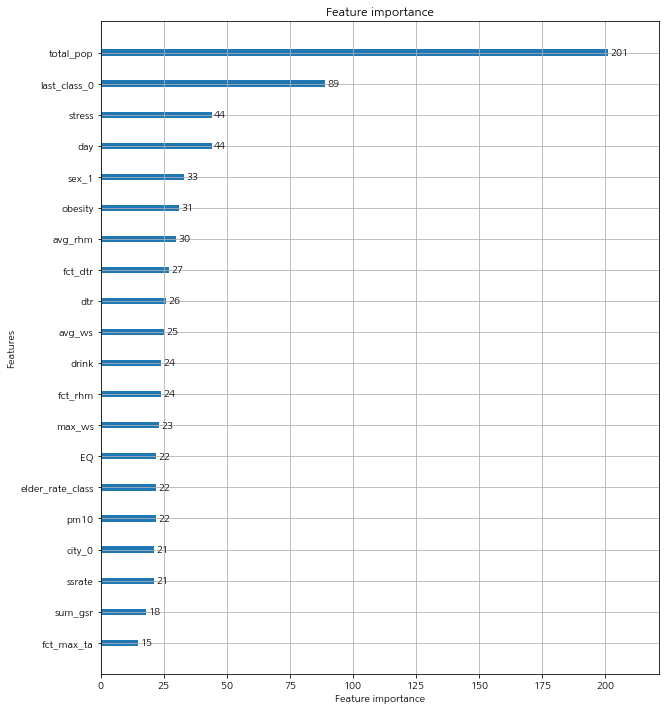

In [39]:
fig, ax = plt.subplots(figsize = (10, 12))

lgb.plot_importance(lgbm,ax =ax,max_num_features=20)


# 파일 저장

최종 예측값에 대하여 음수가 나올 경우를 대비하여 최댓값을 0으로 설정하는 작업을 추가로 실시하여 csv 파일 저장

In [40]:
final_pred = lgbm.predict(test_2_dummy)
final_pred = np.maximum(0, final_pred)

In [41]:
submission = pd.read_csv('2-2_검증데이터셋.csv', encoding = 'euc-kr')
submission

,yyyymmdd,area,sex,frequency
0,2016-01-01,강원,1,NaN
1,2016-01-01,경기,1,NaN
2,2016-01-01,경남,1,NaN
3,2016-01-01,경북,1,NaN
4,2016-01-01,광주,1,NaN
...,...,...,...,...
12439,2016-12-31,전남,2,NaN
12440,2016-12-31,전북,2,NaN
12441,2016-12-31,제주,2,NaN
12442,2016-12-31,충남,2,NaN


In [42]:
submission['frequency'] = final_pred  
submission

,yyyymmdd,area,sex,frequency
0,2016-01-01,강원,1,1.170891
1,2016-01-01,경기,1,4.528995
2,2016-01-01,경남,1,2.049701
3,2016-01-01,경북,1,1.915358
4,2016-01-01,광주,1,0.704487
...,...,...,...,...
12439,2016-12-31,전남,2,2.590440
12440,2016-12-31,전북,2,2.414557
12441,2016-12-31,제주,2,0.495022
12442,2016-12-31,충남,2,1.824426


In [43]:
#마지막으로 frequency에 대한 최댓값, 최솟값 확인
print(submission['frequency'].max())
print(submission['frequency'].min())

5.83238335339996
0.0


In [44]:
submission.to_csv('220167.csv', index = False)
pd.read_csv('220167.csv')

,yyyymmdd,area,sex,frequency
0,2016-01-01,강원,1,1.170891
1,2016-01-01,경기,1,4.528995
2,2016-01-01,경남,1,2.049701
3,2016-01-01,경북,1,1.915358
4,2016-01-01,광주,1,0.704487
...,...,...,...,...
12439,2016-12-31,전남,2,2.590440
12440,2016-12-31,전북,2,2.414557
12441,2016-12-31,제주,2,0.495022
12442,2016-12-31,충남,2,1.824426
